Импортируем нужные библиотеки.

In [1]:
import torch
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

from torch.nn import CTCLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from torchmetrics import CharErrorRate
from ctc_decoder import beam_search

from dataset import CaptchaDataset
from models import Net

Далее инициализируем список токенов буквами английского алфавита и арабскими цифрами + blank (пустой) токен. Будем предполагать, что только они могут встречаться в капчах.  
Также сделаем словари для перевода токена в индекс и наоборот.

In [2]:
ALPHABET = "a b c d e f g h i j k l m n o p q r s t u v w x y z"
DIGITS = "1 2 3 4 5 6 7 8 9 0"

tokens = [".", *(ALPHABET.split(" ")), *(DIGITS.split(" "))]
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

Далее создадим даталоудеры для тренировочного и тестового наборов.  
Датасет из себя представляем набор пар: картинка (в RGB) и набор из пяти токенов (буква или цифра).  
В качестве препоцессинга используем нормализацию изображений со значениями mean и std из ImageNet, перевод картинки в тензор. Токены переведем в индексы, а их - в тензор.

In [3]:
IMAGE_MEAN = [0.485, 0.456, 0.406]
IMAGE_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])
target_transform = transforms.Compose([
    lambda target_str: [token_to_idx[ch] for ch in target_str],
    torch.Tensor
])

trainset = CaptchaDataset(
    is_train=True,
    transform=transform,
    target_transform=target_transform
)
testset = CaptchaDataset(
    is_train=False,
    transform=transform,
    target_transform=target_transform
)

batch_size = 64
current_cpu_count = multiprocessing.cpu_count()
trainloader = DataLoader(trainset, batch_size=batch_size,
                         shuffle=True, num_workers=current_cpu_count)
testloader = DataLoader(testset, batch_size=batch_size,
                        shuffle=False, num_workers=current_cpu_count)

Тут просто визуализация данных.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


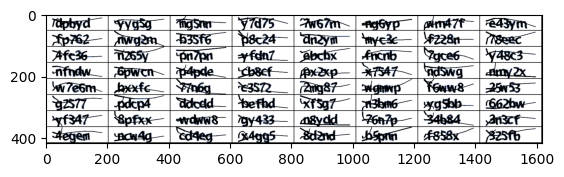

['dpbyd', 'yyg5g', 'mg5nn', 'y7d75', '7w67m', 'ng6yp', 'wm47f', 'e43ym', 'fp762', 'nwg2m', 'b35f6', 'p8c24', 'dn2ym', 'myc3c', 'f228n', '78eec', '4fc36', 'n265y', 'pn7pn', 'yfdn7', 'ebcbx', 'fncnb', '7gce6', 'y48c3', 'nfndw', '6pwcn', 'p4pde', 'cb8cf', 'px2xp', 'x7547', 'nd5wg', 'nmy2x', 'w7e6m', 'bxxfc', '77n6g', 'c3572', '2mg87', 'wgnwp', 'f6ww8', '25w53', 'g2577', 'pdcp4', 'ddcdd', 'befbd', 'xf5g7', 'n3bm6', 'yg5bb', '662bw', 'yf347', '8pfxx', 'wdww8', 'gy433', 'n8ydd', '76n7p', '34b84', '3n3cf', '4egem', 'ncw4g', 'cd4eg', 'x4gg5', '8d2nd', 'b5pnn', 'f858x', '325fb']


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

letters_labels = []
for label in labels:
    letters_labels.append("".join([idx_to_token[idx.item()] for idx in label]))
    
print(letters_labels)

Надеюсь, у вас есть cuda :)

In [5]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

Создадим инстанс класса нашей сети. Архитектуру можно глянуть в файлике models.py.  
В целом все стандартно: CNN, LSTM, FC. Немного reshape и permute, чтобы подружить свертку и рекуррентку.

In [6]:
net = Net(len(tokens)).to(device)

Рутина обучения, тут все тоже стандартно. CTCLoss считается ровно как в [примере из доки](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html).

In [7]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    loss_history = []
    for epoch in range(num_epochs):
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            pred = net(inputs.to(device))
            pred = pred.permute(1, 0, 2)
            
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=pred.shape[0], dtype=torch.long)
            target_lengths = torch.full(size=(inputs.shape[0],), fill_value=labels.shape[1], dtype=torch.long)
            
            loss = criterion(pred.log_softmax(-1), labels, input_lengths, target_lengths)
            loss_history.append(loss.item())
            
            loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()

        if epoch % 10 == 9:
            print(f"Epoch: {epoch + 1}, current_loss: {loss.item()}, mean loss through the history: {sum(loss_history) / len(loss_history)}")

    print('Finished Training')
    
    return net

Отпимизатор - Адам. Лосс - CTCLoss.

In [8]:
optimizer = Adam(net.parameters())
criterion = CTCLoss()

Треним много эпох, я рил надеюсь, что у вас есть gpu :)

In [9]:
net = train_model(net, criterion, optimizer, trainloader, 200)

Epoch: 10, current_loss: 0.10247351229190826, mean loss through the history: 1.1760406617648327
Epoch: 20, current_loss: 0.04583006352186203, mean loss through the history: 0.6102827741442105
Epoch: 30, current_loss: 0.06328308582305908, mean loss through the history: 0.41591090924966223
Epoch: 40, current_loss: 0.006806022487580776, mean loss through the history: 0.3158995885007943
Epoch: 50, current_loss: 0.015406826511025429, mean loss through the history: 0.2555902221795315
Epoch: 60, current_loss: 0.0005893658380955458, mean loss through the history: 0.21355279617668996
Epoch: 70, current_loss: 0.00046960401232354343, mean loss through the history: 0.1833752427986378
Epoch: 80, current_loss: 0.00023602123837918043, mean loss through the history: 0.16050622534540498
Epoch: 90, current_loss: 0.00028319403645582497, mean loss through the history: 0.14269817094247675
Epoch: 100, current_loss: 0.0001452841388527304, mean loss through the history: 0.1284458301144164
Epoch: 110, current_

Ну и наконец CharErrorRate.

In [10]:
labels_preds = []
labels_reals = []

char_error_rate = CharErrorRate()
char_error_rate_history = []
with torch.no_grad():
    for inputs, labels in testloader:
        labels = labels.to(device)
        
        pred_probs = net(inputs.to(device)).softmax(-1)
        
        labels_pred = []
        for batch_item in pred_probs:
            letters_pred = []
            for probs in batch_item.cpu():
                letters_pred.append([*[item.item() for item in probs[1:]], probs[:1].item()])
            tokens_pred = beam_search(np.array([np.array(xi) for xi in letters_pred]), tokens[1:])
            labels_pred.append(tokens_pred)
            labels_preds.append(tokens_pred)
        
        labels_real = []
        for label in labels:
            tokens_real = "".join([idx_to_token[item.item()] for item in label])
            labels_real.append(tokens_real)
            labels_reals.append(tokens_real)
            
        
        char_error_rate_history.append(char_error_rate(labels_real, labels_pred).item())

print(f"Char Error Rates on test data: {char_error_rate_history}")
print(f"Mean Char Error Rate on test data: {sum(char_error_rate_history) / len(char_error_rate_history)}")

Char Error Rates on test data: [0.01587301678955555, 0.03833865746855736, 0.015772869810461998, 0.012658228166401386]
Mean Char Error Rate on test data: 0.020660693058744073


В среднем ошибаемся в <5% случаях, что считаю вполне неплохим результатом.

Теперь посмотрим на наши предсказания и попытаемся понять, какие у модели проблемы.

In [11]:
for i, _ in enumerate(labels_reals):
    real = labels_reals[i]
    pred = labels_preds[i]
    print(f"{real} : {pred}")

2g783 : 2g783
cfc2y : cfc2y
f4fn2 : f4fn2
5nnff : 5nff
7e2y7 : 7e2y7
cc845 : cc845
58b5m : 58b5m
62nb3 : 62nb3
7f8b3 : 7f8b3
8n65n : 8n65n
m448b : m48b
d378n : d378n
gpxng : gpxg
nny5e : nny5e
6fg8c : 6fg8c
5f3gf : 5f3gf
8bbw8 : 8bbw8
g3dy6 : g3dy6
dmw8n : dmw8n
7bb7b : 7b7b
226md : 226md
23n88 : 23n88
467d5 : 467d5
d7c5x : d7c5x
pgmn2 : pgmn2
xe8xm : xe8xm
68x48 : 68x48
6fn84 : 6fn84
nw5b2 : nw5b2
f83pn : f83pn
gecmf : gecmf
8n56m : 8n56m
43p5d : 43p5d
pm47f : pm47f
2gyb6 : 2gyb6
c2fb7 : c2fb7
dbny3 : dbny3
bbymy : bbymy
f8f8g : f8f8g
cdfen : cdfen
ddnpf : ddnpf
ne325 : ne325
y53c2 : y53c2
c8fxy : c8fxy
6mege : 6mege
ggd7m : ggd7m
44fyb : 44fyb
33b22 : 33b22
nf7bn : nf7bn
ffnxn : ffnxn
pmg55 : pmg55
b55d6 : b55d6
n373n : n373n
5g5e5 : 5g5e5
gc83b : gc83b
xbcbx : xbcbx
d22n7 : d2n7
4ynf3 : 4ynf3
5wddw : 5wddw
87d4c : 87d4c
gd8fb : gd8fb
8fexn : 8fexn
wecfd : wecfd
cnex4 : cnex4
24pew : 24pew
m3wfw : m3wfw
7m8px : 7m8px
e3ndn : e3ndn
5fyem : 5fyem
bn5mw : bn5mw
37d52 : 37d52
3p67n : 3p6

Невооруженным глазом видно, что модель чаще ошибается на картинках, где есть повторы токенов.  
* 5*nn*ff : 5*n*ff
* m*44*8b : m*4*8b
* 3*nn*pw : 3*n*pw
* pyb*ee* : pyb*e*  

К тому же этих самых предсказанных токенов всегда меньше, чем нужно (<5).  
Это, в первую очередь, связано с самим CTCLoss, т к он больше предназначен для распознавания последовательностей разной длинны. То есть мы теряем приемущество в виде гарантии того, что у нас в капче символов ровно 5. Но с другой стороны, никто нигде этого не говорил :)  

Другое предположение строится на том, что таких капч (где повторяюся токены) в датасете немного. Поэтому можно было бы попробовать аугментировать некоторые из этих капч, дабы модель лучше научилась распознавать такие случае.  

Ну и плюс ко всему сами данные кривые. С разметкой нужно бы еще поработать, поэтому идеального результата тут в любом случае не будет :)